<a href="https://colab.research.google.com/github/gulshan0201/DATA-Science/blob/main/DS_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

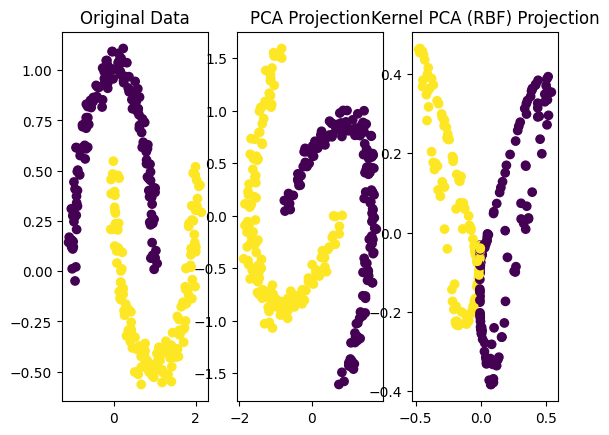

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

# Generate synthetic non-linear dataset (two moons)
X, y = make_moons(n_samples=300, noise=0.05, random_state=42)

# Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X_scaled)

# Plot Original Data
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')
plt.title("Original Data")

# Plot PCA
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis')
plt.title("PCA Projection")

# Plot Kernel PCA
plt.subplot(1, 3, 3)
plt.scatter(X_kpca[:,0], X_kpca[:,1], c=y, cmap='viridis')
plt.title("Kernel PCA (RBF) Projection")

plt.show()


In [ ]:
!pip install numpy scikit-learn matplotlib


=== PCA vs Kernel PCA — Metrics ===
         method  n_samples  n_components  recon_MSE (std space)  explained_variance_sum kernel    gamma
            PCA       4000             2               0.152466                0.772552   None      NaN
KernelPCA (RBF)       4000             2               0.270989                     NaN    rbf 0.188132


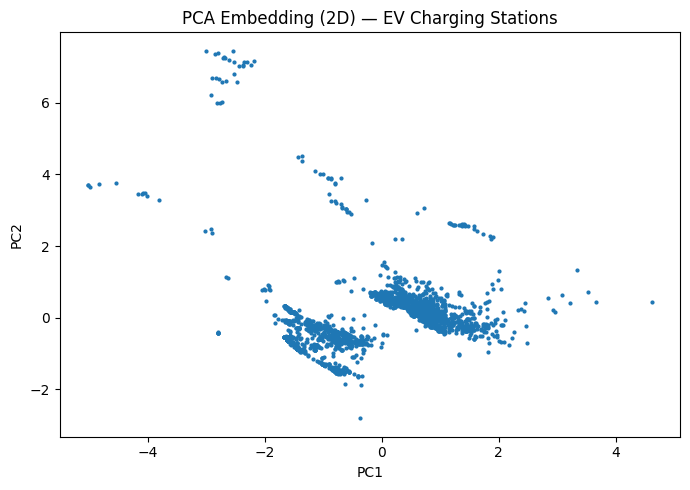

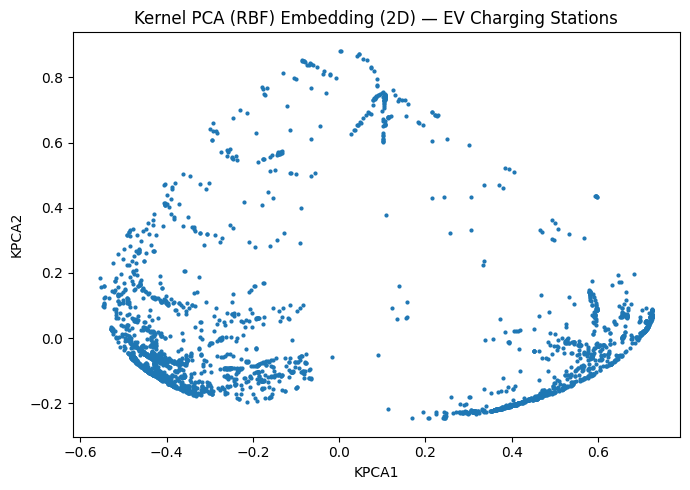

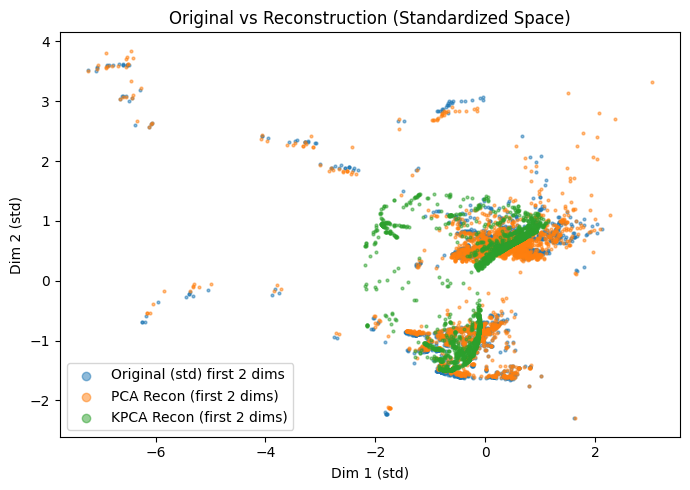

In [ ]:
# PCA vs Kernel PCA on EV charging stations (2025 world dataset)
# --------------------------------------------------------------
# Requirements: pip install numpy pandas scikit-learn matplotlib
# File expected at: /mnt/data/charging_stations_2025_world.csv  (change PATH if needed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import pairwise_distances

# -----------------------
# Config (tunable)
# -----------------------
DATA_PATH = Path("charging_stations_2025_world.csv")  # <-- change if needed
FEATURES = ["latitude", "longitude", "ports", "power_kw"]
N_COMPONENTS = 2
RANDOM_STATE = 42

# Kernel PCA can be heavy (O(n^2)), so we sub-sample safely:
KPCA_SAMPLE_SIZE = 4000       # used for both PCA and KPCA to compare fairly
GAMMA_SUBSAMPLE = 500         # subset size to estimate RBF gamma via median distance
PLOT_SAMPLE = 3000            # points to show in each scatter for readability

# -----------------------
# 1) Load + Preprocess
# -----------------------
df = pd.read_csv(DATA_PATH)
X = df[FEATURES].copy()

# Drop missing; filter obvious non-sensical entries
X = X.dropna()
if "power_kw" in X: X = X[X["power_kw"] > 0]
if "ports"    in X: X = X[X["ports"] > 0]

# Standardize (very important for PCA/KPCA)
scaler = StandardScaler()
X_std = scaler.fit_transform(X.values)

n_total = X_std.shape[0]
rng = np.random.default_rng(RANDOM_STATE)

# Subset for manageable KPCA (and use same subset for PCA to compare apples-to-apples)
kpca_n = min(KPCA_SAMPLE_SIZE, n_total)
kpca_idx = rng.choice(n_total, size=kpca_n, replace=False)
X_kpca = X_std[kpca_idx]

# Separate subset for plotting
plot_n = min(PLOT_SAMPLE, kpca_n)
plot_idx_local = rng.choice(kpca_n, size=plot_n, replace=False)
X_plot = X_kpca[plot_idx_local]

# -----------------------
# 2) PCA (2 components)
# -----------------------
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
Z_pca = pca.fit_transform(X_kpca)
Xrec_pca = pca.inverse_transform(Z_pca)

# Reconstruction MSE in standardized space
pca_mse = float(np.mean((X_kpca - Xrec_pca) ** 2))
pca_explained = float(pca.explained_variance_ratio_.sum())

# -----------------------
# 3) Kernel PCA (RBF)
#    - gamma chosen via median pairwise distance heuristic
# -----------------------
gamma_subset_n = min(GAMMA_SUBSAMPLE, kpca_n)
gamma_idx = rng.choice(kpca_n, size=gamma_subset_n, replace=False)
X_gamma = X_kpca[gamma_idx]

# Median pairwise distance (avoid diagonal)
d = pairwise_distances(X_gamma, metric="euclidean")
median_dist = np.median(d[np.triu_indices_from(d, k=1)])
if median_dist <= 1e-12:  # degenerate edge case
    median_dist = 1.0

# RBF gamma ≈ 1 / (2 * sigma^2), with sigma ≈ median_dist
gamma = 1.0 / (2.0 * (median_dist ** 2))

kpca = KernelPCA(
    n_components=N_COMPONENTS,
    kernel="rbf",
    gamma=gamma,
    fit_inverse_transform=True,  # enables pre-image approximation for inverse_transform
    random_state=RANDOM_STATE
)
Z_kpca = kpca.fit_transform(X_kpca)
Xrec_kpca = kpca.inverse_transform(Z_kpca)
kpca_mse = float(np.mean((X_kpca - Xrec_kpca) ** 2))

# -----------------------
# 4) Comparison Table
# -----------------------
summary = pd.DataFrame([
    {
        "method": "PCA",
        "n_samples": kpca_n,
        "n_components": N_COMPONENTS,
        "recon_MSE (std space)": pca_mse,
        "explained_variance_sum": pca_explained,
        "kernel": None,
        "gamma": None,
    },
    {
        "method": "KernelPCA (RBF)",
        "n_samples": kpca_n,
        "n_components": N_COMPONENTS,
        "recon_MSE (std space)": kpca_mse,
        "explained_variance_sum": None,  # not directly comparable in KPCA
        "kernel": "rbf",
        "gamma": gamma,
    }
])
print("\n=== PCA vs Kernel PCA — Metrics ===")
print(summary.to_string(index=False))

# -----------------------
# Plots (plain matplotlib; one figure each; no custom colors)
# -----------------------

# PCA embedding
plt.figure(figsize=(7,5))
plt.scatter(Z_pca[plot_idx_local, 0], Z_pca[plot_idx_local, 1], s=4)
plt.title("PCA Embedding (2D) — EV Charging Stations")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

# Kernel PCA embedding
plt.figure(figsize=(7,5))
plt.scatter(Z_kpca[plot_idx_local, 0], Z_kpca[plot_idx_local, 1], s=4)
plt.title("Kernel PCA (RBF) Embedding (2D) — EV Charging Stations")
plt.xlabel("KPCA1"); plt.ylabel("KPCA2")
plt.tight_layout(); plt.show()

# Reconstruction comparison (first two standardized dims)
plt.figure(figsize=(7,5))
plt.scatter(X_plot[:, 0], X_plot[:, 1], s=4, alpha=0.5, label="Original (std) first 2 dims")
plt.scatter(Xrec_pca[plot_idx_local, 0], Xrec_pca[plot_idx_local, 1], s=4, alpha=0.5, label="PCA Recon (first 2 dims)")
plt.scatter(Xrec_kpca[plot_idx_local, 0], Xrec_kpca[plot_idx_local, 1], s=4, alpha=0.5, label="KPCA Recon (first 2 dims)")
plt.title("Original vs Reconstruction (Standardized Space)")
plt.xlabel("Dim 1 (std)"); plt.ylabel("Dim 2 (std)")
plt.legend(markerscale=3)
plt.tight_layout(); plt.show()




Generated dataset shape: (10000, 64) (rows, cols)


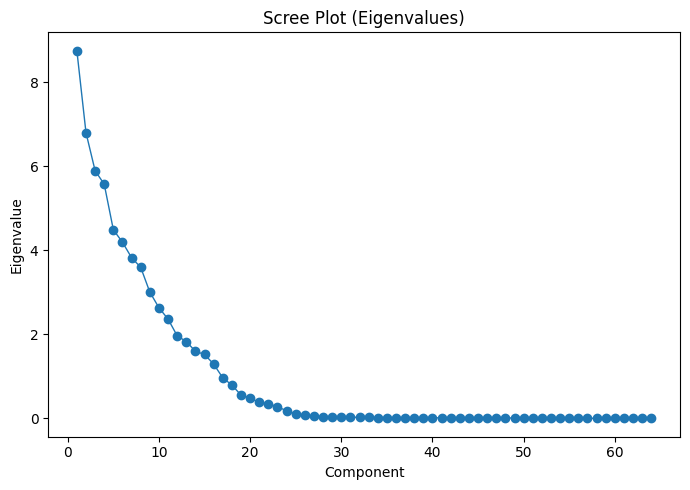

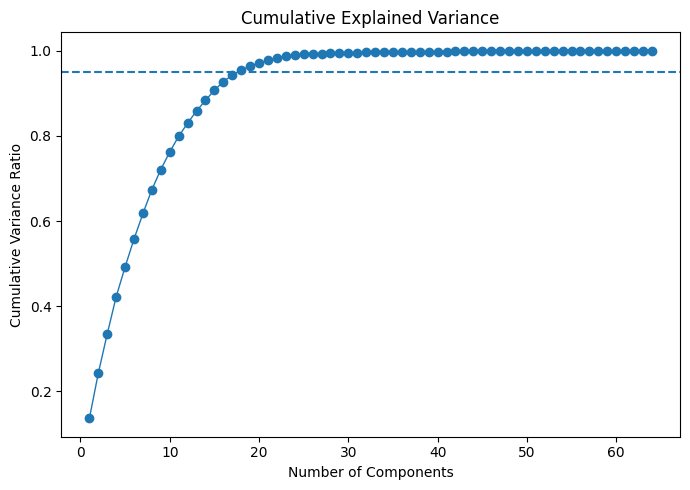

[PCA] components=  2 | recon_MSE(std-space)=0.756920 | explained_var_sum=0.2431
[PCA] components=  5 | recon_MSE(std-space)=0.507463 | explained_var_sum=0.4925
[PCA] components= 10 | recon_MSE(std-space)=0.237768 | explained_var_sum=0.7622
[PCA] components= 20 | recon_MSE(std-space)=0.028878 | explained_var_sum=0.9711
[PCA] components= 30 | recon_MSE(std-space)=0.004971 | explained_var_sum=0.9950
[PCA] components= 40 | recon_MSE(std-space)=0.002137 | explained_var_sum=0.9979


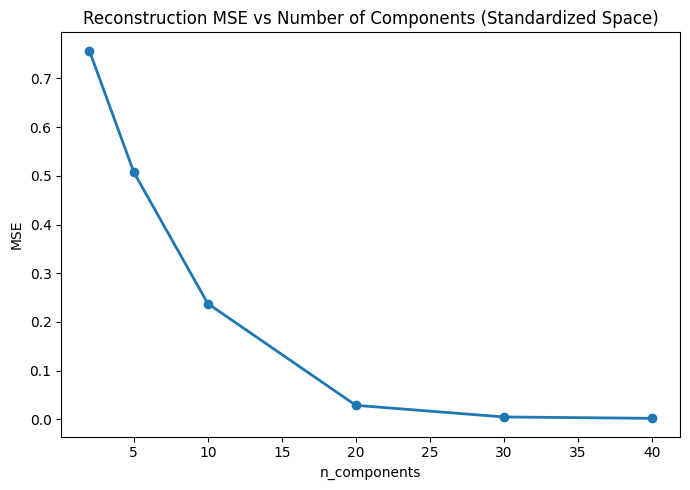


[Auto PCA] variance_threshold=0.95 -> chosen components=18 | recon_MSE=0.045055 | explained_var_sum=0.9549


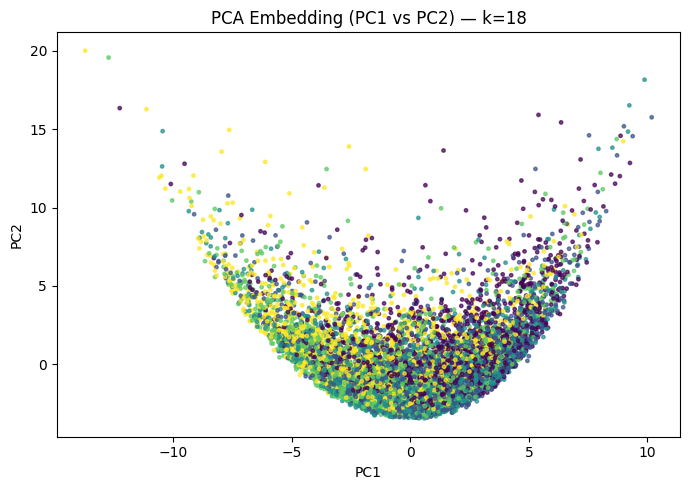


Top 10 loadings for PC1:
feature   loading
 lin_26  0.299370
 lin_15 -0.286809
  lin_3 -0.280526
  lin_8 -0.274290
 lin_24  0.269005
  lin_9 -0.241954
 lin_27 -0.229121
 lin_11 -0.228540
  lin_7  0.220060
 lin_23 -0.217325

Top 10 loadings for PC2:
 feature   loading
 poly2_3  0.264945
poly2_21  0.247930
 inter_4 -0.246687
poly2_23  0.236218
 poly2_5  0.227754
 inter_2  0.223027
poly2_10  0.205941
poly2_24  0.205007
poly2_22  0.199716
 inter_6  0.190273


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -----------------------
# Config
# -----------------------
RANDOM_STATE = 42
N_SAMPLES    = 10_000
LATENT_K     = 6             # latent factors used to generate structure
N_LINEAR     = 30            # linear mix features
N_POLY       = 24            # polynomial (squared) features
N_INTERACT   = 10            # interaction features # Reduced N_INTERACT
NOISE_STD    = 0.3           # noise scale for features
N_COMPONENTS_LIST = [2, 5, 10, 20, 30, 40]  # evaluate these PCA sizes
USE_VARIANCE_THRESHOLD = True
VARIANCE_THRESHOLD     = 0.95  # keep enough PCs to explain this fraction (applied once)

rng = np.random.default_rng(RANDOM_STATE)

# -----------------------
# 1) Generate high-dimensional data (≈84 cols)
#    - Start with LATENT_K latent factors ~ N(0, 1)
#    - Create linear combos -> N_LINEAR features
#    - Add polynomial (squared) and pairwise interactions
#    - Add small gaussian noise
# -----------------------
Z = rng.normal(size=(N_SAMPLES, LATENT_K))  # latent factors

# Random linear mixing matrix (for linear features)
W_linear = rng.normal(size=(LATENT_K, N_LINEAR))
X_linear = Z @ W_linear

# Polynomial features (squares of a random selection of linear features)
poly_idx = rng.choice(N_LINEAR, size=N_POLY, replace=False)
X_poly = X_linear[:, poly_idx] ** 2

# Interaction features between random pairs of linear features
pairs = rng.choice(N_LINEAR, size=(N_INTERACT, 2), replace=False)
X_inter = np.empty((N_SAMPLES, N_INTERACT), dtype=float)
for j, (a, b) in enumerate(pairs):
    X_inter[:, j] = X_linear[:, a] * X_linear[:, b]

# Stack all parts
X = np.hstack([X_linear, X_poly, X_inter])

# Additive noise to each feature
X += rng.normal(scale=NOISE_STD, size=X.shape)

# Optional: create a pseudo-target/label to visualize structure (not used for PCA)
# e.g., cluster-like labels based on a latent factor
y_bucket = pd.qcut(Z[:, 0], q=5, labels=False)  # 5 quantile buckets for PC scatter coloring

# Name columns
cols = (
    [f"lin_{i+1}" for i in range(N_LINEAR)] +
    [f"poly2_{i+1}" for i in range(N_POLY)] +
    [f"inter_{i+1}" for i in range(N_INTERACT)]
)
df = pd.DataFrame(X, columns=cols)

print(f"Generated dataset shape: {df.shape} (rows, cols)")

# -----------------------
# 2) Standardize
# -----------------------
scaler = StandardScaler()
X_std = scaler.fit_transform(df.values)

# -----------------------
# 3) PCA (Scree + Cumulative Variance once on full standardized data)
# -----------------------
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_std)
eigs = pca_full.explained_variance_
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# Plot: Scree (eigenvalues)
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, len(eigs) + 1), eigs, marker='o', linewidth=1)
plt.title("Scree Plot (Eigenvalues)")
plt.xlabel("Component")
plt.ylabel("Eigenvalue")
plt.tight_layout()
plt.show()

# Plot: Cumulative explained variance
plt.figure(figsize=(7, 5))
plt.plot(np.arange(1, len(cumvar) + 1), cumvar, marker='o', linewidth=1)
plt.axhline(y=VARIANCE_THRESHOLD, linestyle='--')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Ratio")
plt.tight_layout()
plt.show()

# -----------------------
# 4) Evaluate selected PCA sizes (reconstruction + MSE)
# -----------------------
def recon_mse_for_components(k: int) -> float:
    pca = PCA(n_components=k, random_state=RANDOM_STATE)
    Zk = pca.fit_transform(X_std)
    Xrec = pca.inverse_transform(Zk)
    return float(np.mean((X_std - Xrec) ** 2)), Zk, Xrec, pca

results = []
for k in N_COMPONENTS_LIST:
    mse_k, Zk, Xrec_k, pca_k = recon_mse_for_components(k)
    results.append((k, mse_k, pca_k.explained_variance_ratio_.sum()))
    print(f"[PCA] components={k:>3} | recon_MSE(std-space)={mse_k:.6f} | "
          f"explained_var_sum={pca_k.explained_variance_ratio_.sum():.4f}")

# Plot: MSE vs components
plt.figure(figsize=(7, 5))
xs = [r[0] for r in results]
ys = [r[1] for r in results]
plt.plot(xs, ys, marker='o', linewidth=2)
plt.title("Reconstruction MSE vs Number of Components (Standardized Space)")
plt.xlabel("n_components")
plt.ylabel("MSE")
plt.tight_layout()
plt.show()

# -----------------------
# 5) Auto choice by variance threshold (optional single run)
# -----------------------
if USE_VARIANCE_THRESHOLD:
    k_star = int(np.searchsorted(cumvar, VARIANCE_THRESHOLD) + 1)
    mse_star, Z_star, Xrec_star, pca_star = recon_mse_for_components(k_star)
    print(f"\n[Auto PCA] variance_threshold={VARIANCE_THRESHOLD:.2f} "
          f"-> chosen components={k_star} | recon_MSE={mse_star:.6f} | "
          f"explained_var_sum={pca_star.explained_variance_ratio_.sum():.4f}")

    # PC scatter with pseudo-label coloring (first two PCs only for viz)
    if k_star >= 2:
        plt.figure(figsize=(7, 5))
        plt.scatter(Z_star[:, 0], Z_star[:, 1], s=6, c=y_bucket, alpha=0.7)
        plt.title(f"PCA Embedding (PC1 vs PC2) — k={k_star}")
        plt.xlabel("PC1"); plt.ylabel("PC2")
        plt.tight_layout()
        plt.show()

# -----------------------
# 6) Optional: Feature loadings visualization (top contributors to PC1/PC2)
# -----------------------
def top_loadings(pca_model: PCA, feature_names, pc_index=0, top=10):
    # pc_index: 0 -> PC1, 1 -> PC2, etc.
    loadings = pca_model.components_[pc_index]
    idx = np.argsort(np.abs(loadings))[::-1][:top]
    return pd.DataFrame({
        "feature": np.array(feature_names)[idx],
        "loading": loadings[idx]
    })

# Refit PCA to the chosen k (or to 2 for a clean biplot-like glimpse)
k_for_loadings = 2
pca_2 = PCA(n_components=k_for_loadings, random_state=RANDOM_STATE).fit(X_std)
print("\nTop 10 loadings for PC1:")
print(top_loadings(pca_2, df.columns, pc_index=0, top=10).to_string(index=False))
print("\nTop 10 loadings for PC2:")
print(top_loadings(pca_2, df.columns, pc_index=1, top=10).to_string(index=False))